# Introduction
Here we try to use auto-regressive models like seasonal ARIMA to forecast monthly sales.
In the following analysis per ONE store id is done and data prepared to be able to forecast sales for one store

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


# Preprocessing

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt
import daterange as daterange
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## month
df_train['Month'] = pd.DatetimeIndex(df_train['Date']).to_period('M')
df_train['Year'] = pd.DatetimeIndex(df_train['Date']).to_period('Y')
df_train['Month_str'] = df_train['Month'].map(lambda month_period:month_period.strftime('%Y-%m'))

df_train.info()
df_train.head(5)


# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_train_store_1 = df_train_stores.get_group(2).set_index('Date')
sales_zero_idx = df_train_store_1[df_train_store_1['Sales'] == 0].index
df_train_store_1 = df_train_store_1.drop(sales_zero_idx)
#df_train_store_1['2015-01-01':'2015-02-01'].tail(10)
#df_train_store_1.head(10)

def avg_sales_per_period(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales'] / df['Open']
    df_copy['Sales_per_open_days_avg'] = s_tmp.astype('int')
    return df_copy

def avg_sales_per_promodays(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales_per_open_days_avg'] / df['Promo']
    df_copy['Sales_per_promo_days_avg'] = s_tmp.astype('int')
    return df_copy

# resample/groupby MONTH
df_store_1_monthly_sum: DataFrame = df_train_store_1.resample("M").sum()
df_store_1_monthly_sum['Month'] = df_store_1_monthly_sum.index.month
df_store_1_monthly_sum['Year'] = df_store_1_monthly_sum.index.year
df_store_1_monthly_sum = avg_sales_per_period(df_store_1_monthly_sum)
df_store_1_monthly_sum = avg_sales_per_promodays(df_store_1_monthly_sum)
df_store_1_monthly_sum.head(5)

y_t = df_store_1_monthly_sum['Sales_per_open_days_avg']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  bool          
 9   Month          1017209 non-null  period[M]     
 10  Year           1017209 non-null  period[A-DEC] 
 11  Month_str      1017209 non-null  object        
dtypes: bool(3), datetime64[ns](1), int64(4), object(2), period[A-DEC](1), period[M](1)
memory usage: 72.8+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Month_str
0,1,5,2015-07-31,5263,555,True,True,0,True,2015-07,2015,2015-07
1,2,5,2015-07-31,6064,625,True,True,0,True,2015-07,2015,2015-07
2,3,5,2015-07-31,8314,821,True,True,0,True,2015-07,2015,2015-07
3,4,5,2015-07-31,13995,1498,True,True,0,True,2015-07,2015,2015-07
4,5,5,2015-07-31,4822,559,True,True,0,True,2015-07,2015,2015-07


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Month,Year,Sales_per_open_days_avg,Sales_per_promo_days_avg
Date,,,,,,,,,,,
2013-01-31,52,91,115171,14127,26,10,3,1,2013,4429,442
2013-02-28,48,84,111114,13125,24,10,5,2,2013,4629,462
2013-03-31,50,90,130525,14894,25,14,4,3,2013,5221,372
2013-04-30,50,86,116878,14202,25,12,4,4,2013,4675,389
2013-05-31,48,88,116379,14478,24,12,1,5,2013,4849,404


In [ ]:
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y_t: Series, model_fit: ARIMAResults):
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = sns.lineplot(data=pd.DataFrame({'actual': y_t, 'fitted': model_fit.fittedvalues}), ax=axes)
    plt.show()

def errors(y_t, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y_t.index]
    residuals:Series = model_fit.resid[y_t.index]
    return {
        'RMSE': np.sqrt(mean_squared_error(y_t, fitted)),
        'MAPE': mean_absolute_percentage_error(y_t, fitted),
        'MAX_ABS': residuals.abs().max(),
        'MIN_ABS': residuals.abs().min()}




# Seasonality
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

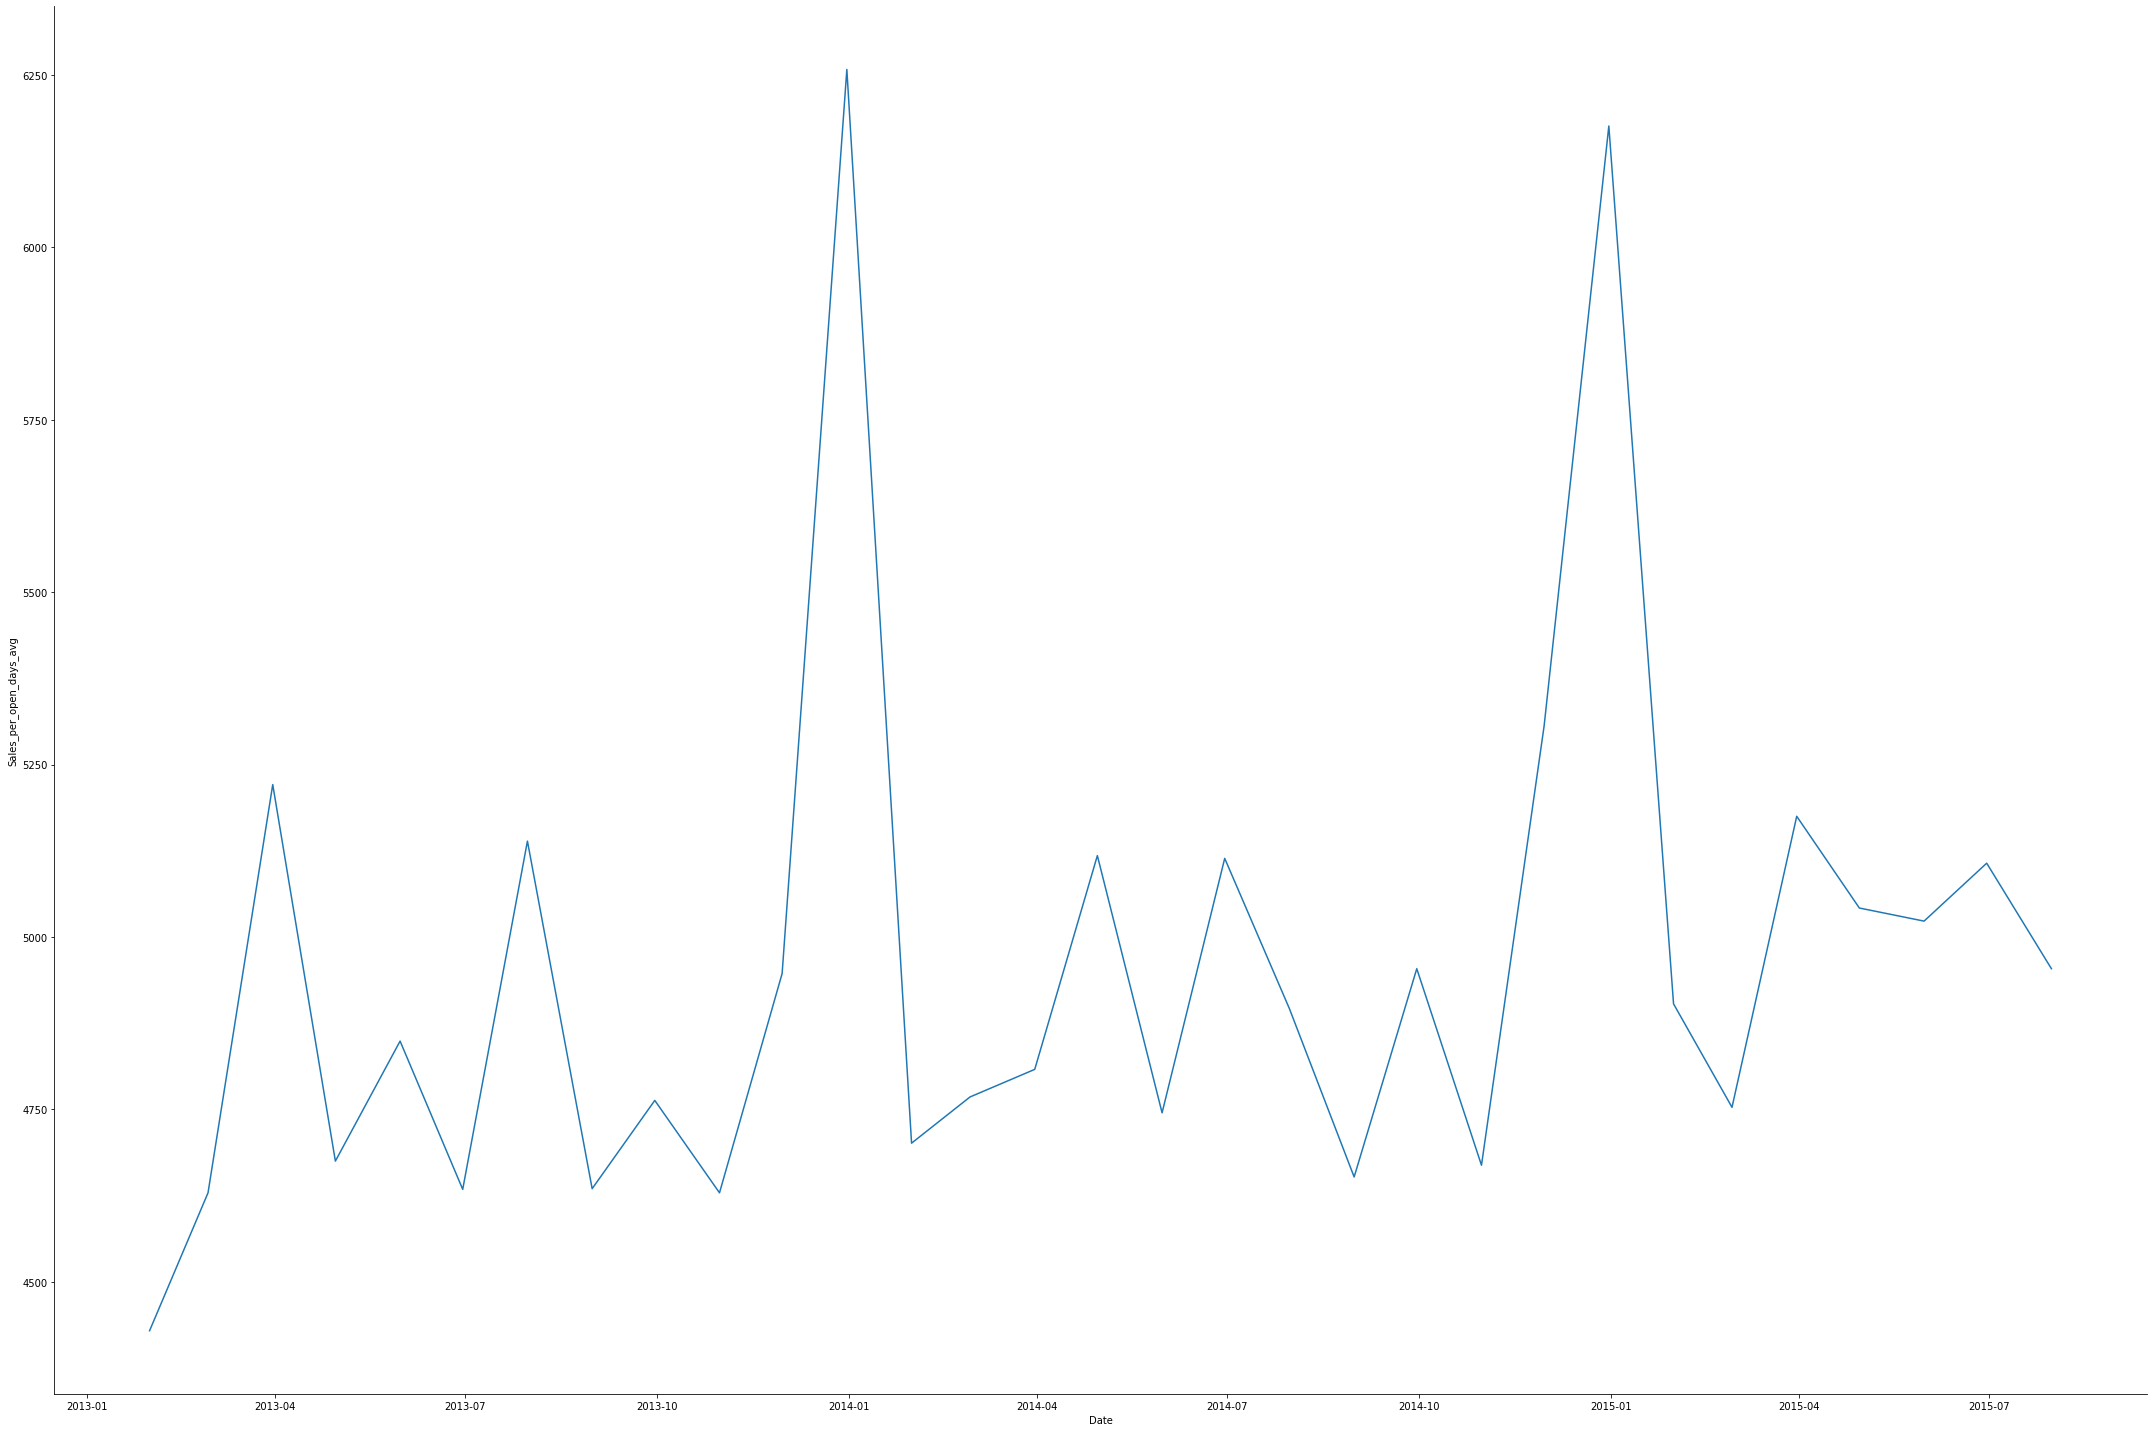

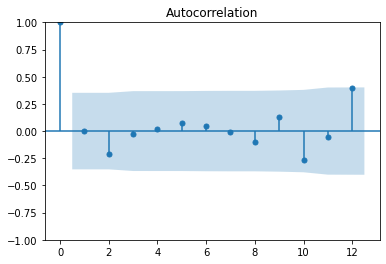

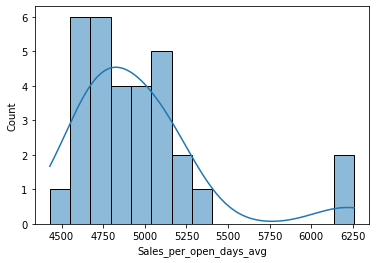

count      31.000000
mean     4957.161290
std       398.283324
min      4429.000000
25%      4688.000000
50%      4896.000000
75%      5110.500000
max      6258.000000
Name: Sales_per_open_days_avg, dtype: float64


In [213]:
# g = sns.relplot(data=df_store_1_monthly_sum.loc['2013-01':],
#                 x="Month",
#                 y='Sales_per_open_days_avg',
#                 hue='Year',
#                 kind='line',
#                 markers=True,
#                 height=20.0, aspect=1.5)
# plt.show()
plot_series_hist_acf_kpss(y_t, lags=12)


# Analysis | Explorative using differencing

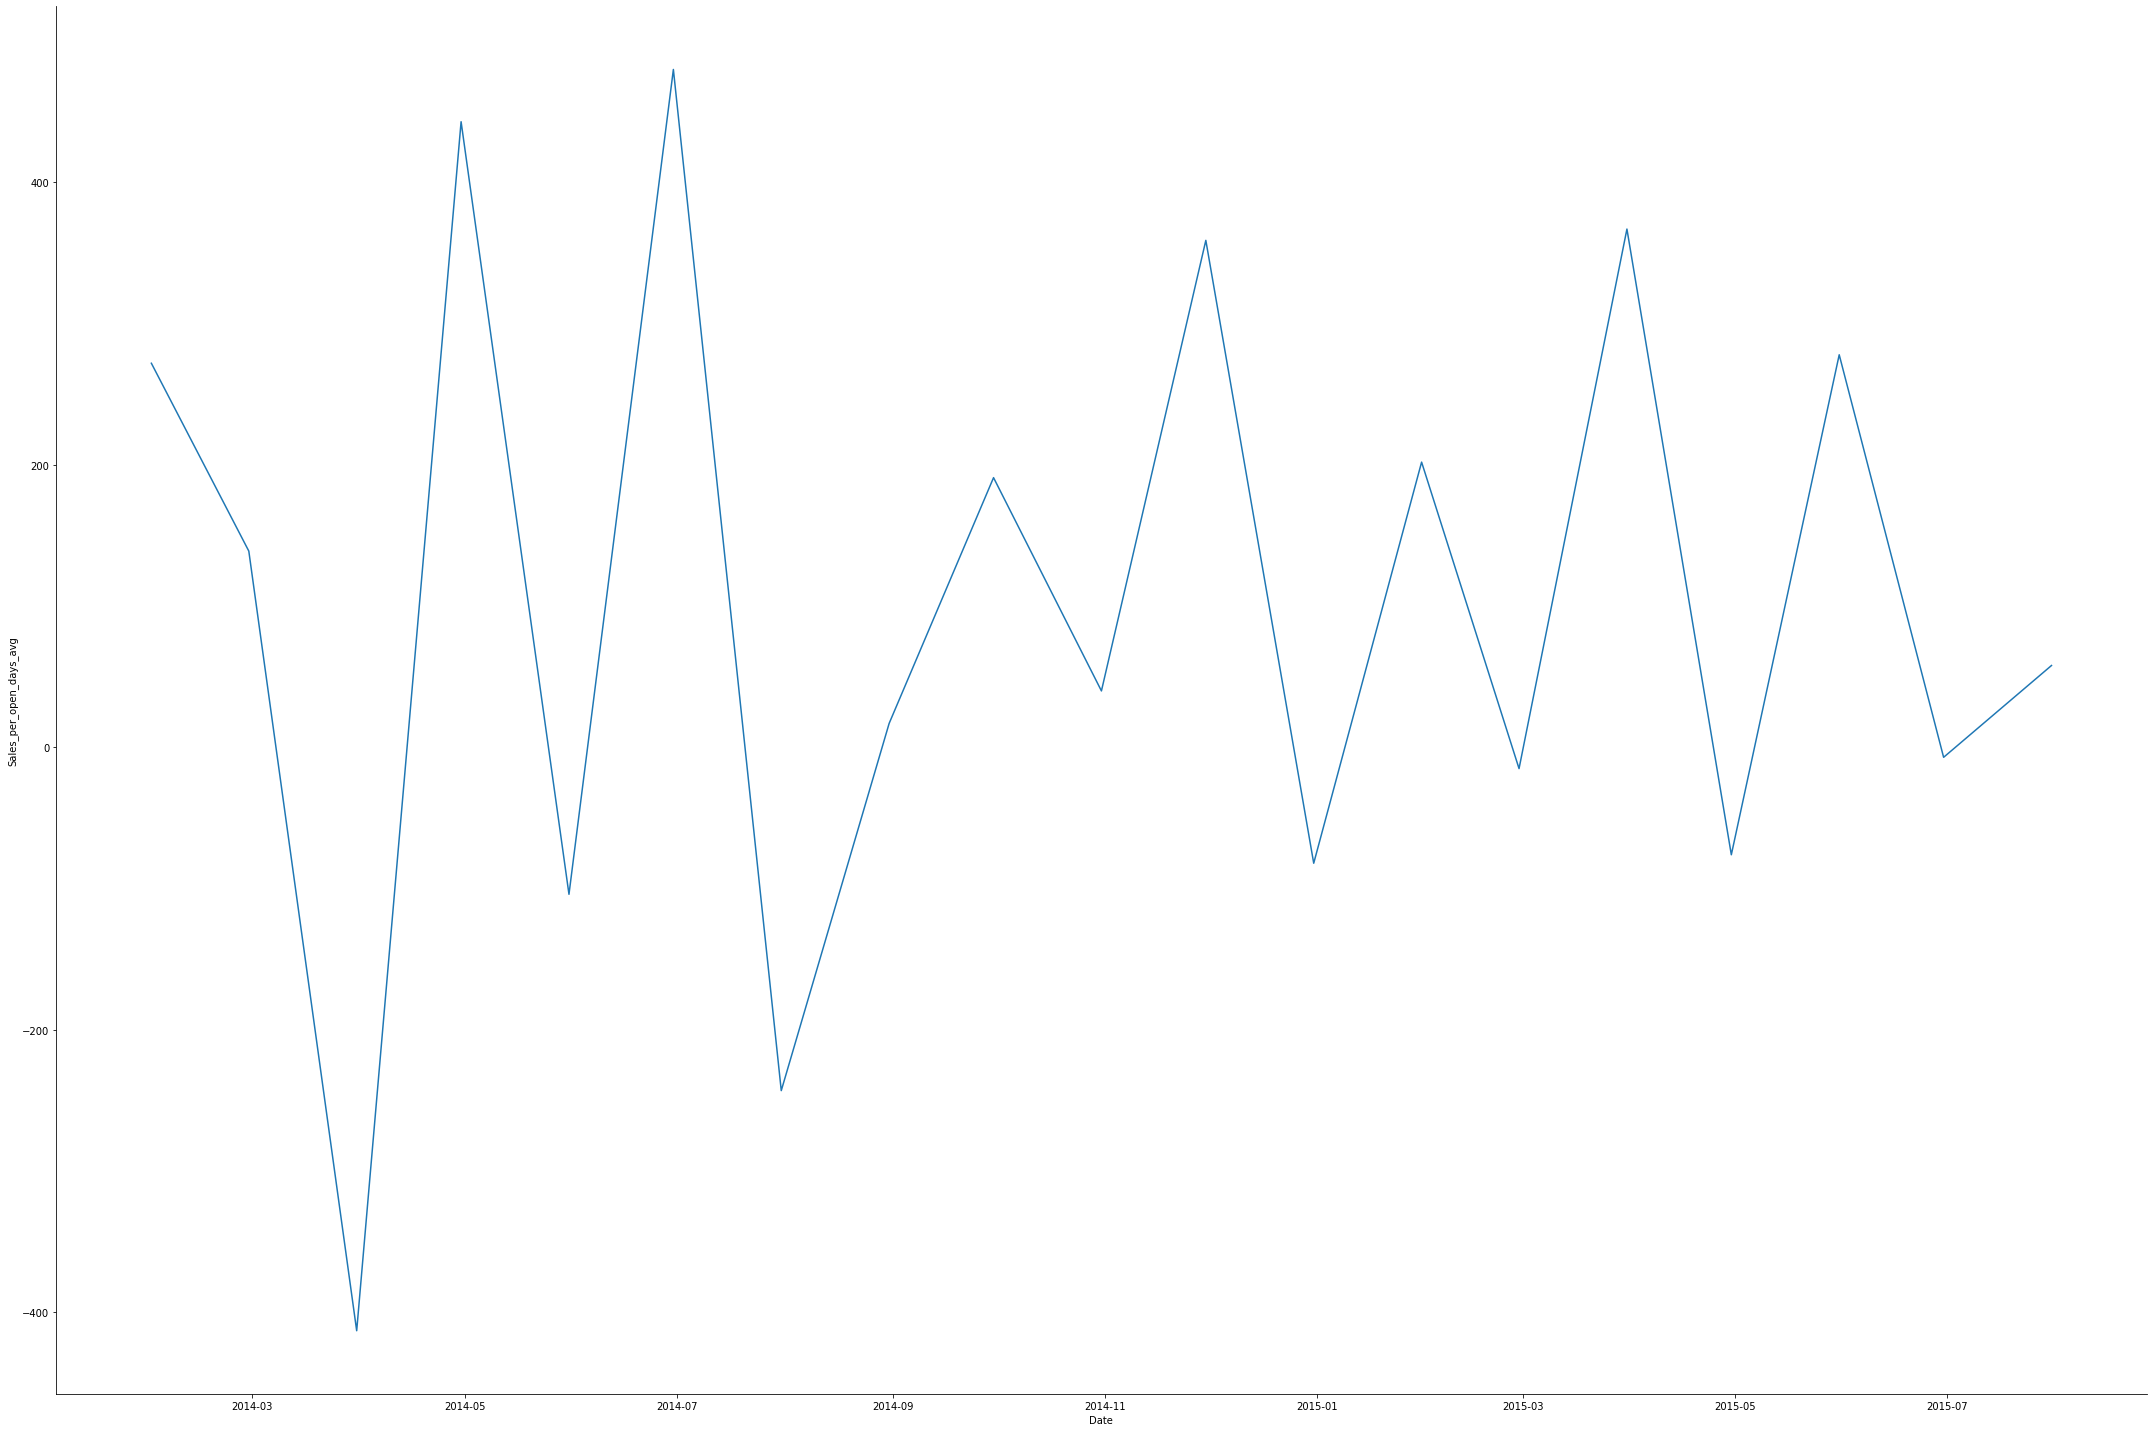

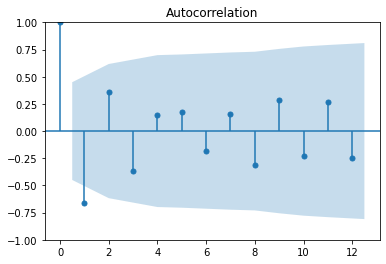

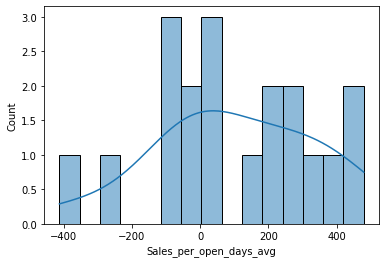

count     19.000000
mean     100.315789
std      236.332170
min     -413.000000
25%      -45.500000
50%       58.000000
75%      275.000000
max      480.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


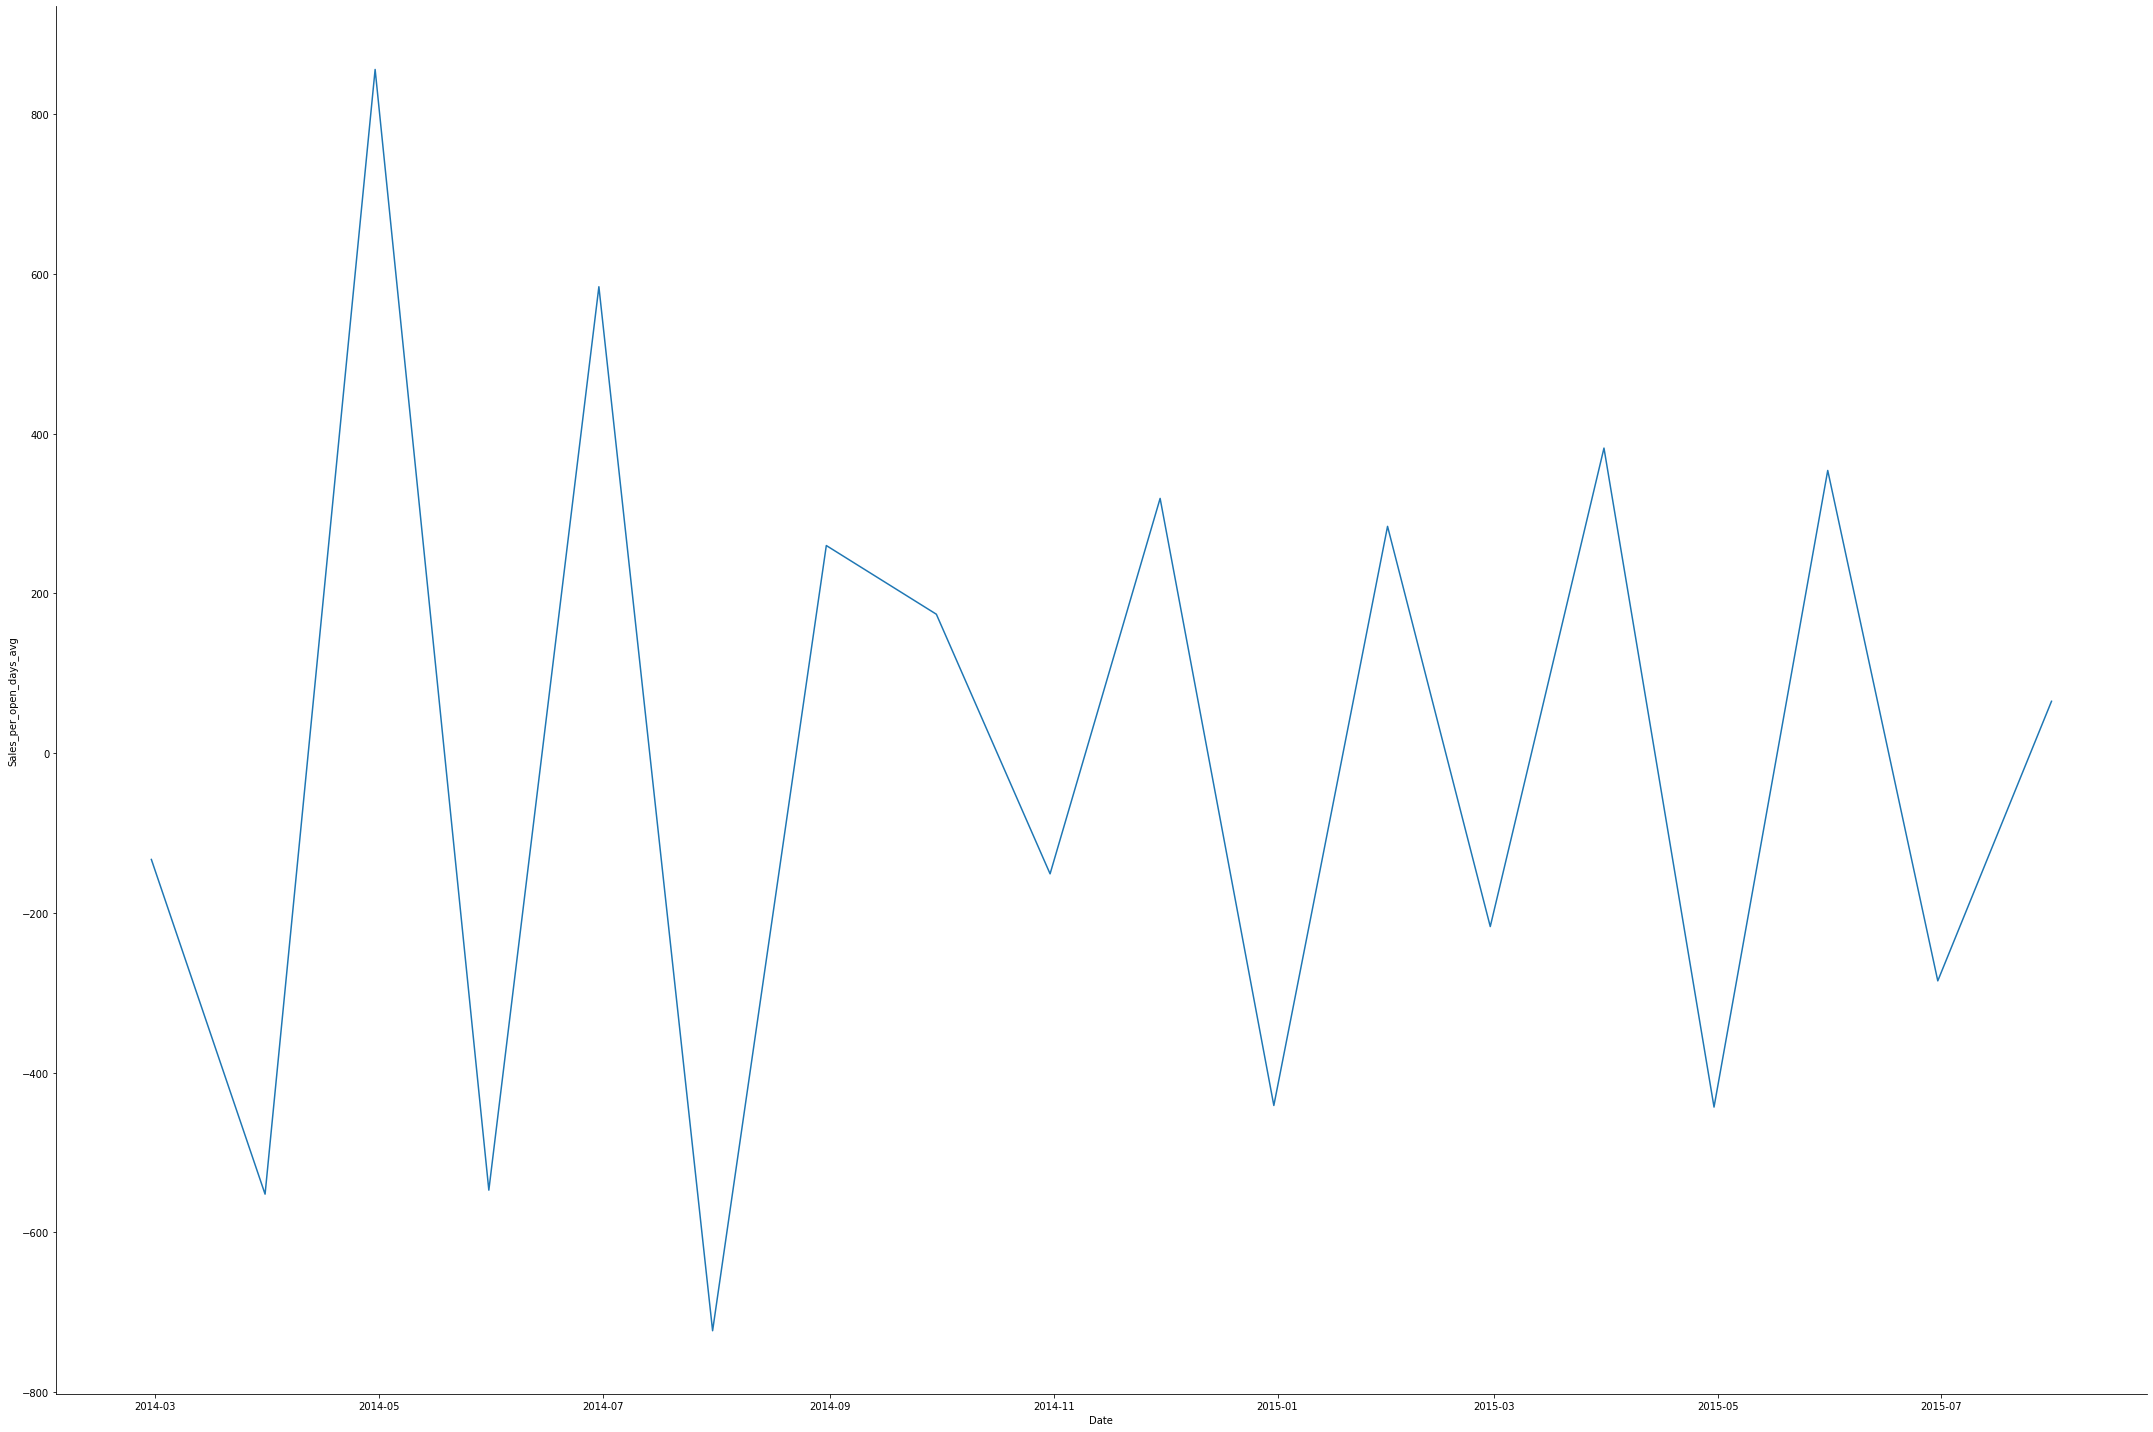

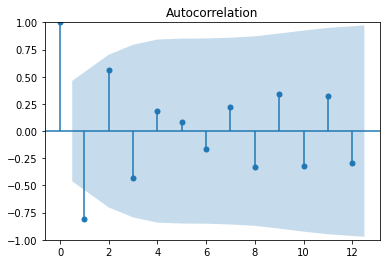

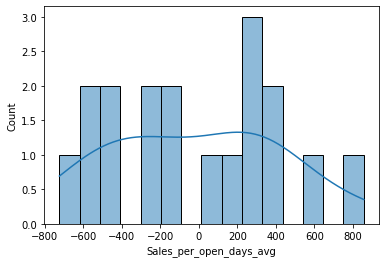

count     18.000000
mean     -11.888889
std      441.466925
min     -723.000000
25%     -402.000000
50%      -34.000000
75%      310.250000
max      856.000000
Name: Sales_per_open_days_avg, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [205]:
from statsmodels.tsa.statespace.tools import diff

# Compared to normalized to avg daily sales per month
# sns.relplot(data=df_store_1_monthly_sum.loc['2013-01':],
#             x='Month',
#             y='Sales_per_open_days_avg',
#             hue='Year',
#             kind='line',
#             markers=True,
#             height=20.0, aspect=1.5)
# plt.show()

#plot_series_hist_acf_kpss(y_t, lags=13)

y_t_diff = diff(series=y_t, k_diff=0, k_seasonal_diff=1, seasonal_periods=12)
plot_series_hist_acf_kpss(y_t_diff, lags=12)

y_t_diff = diff(series=y_t_diff, k_diff=1)
plot_series_hist_acf_kpss(y_t_diff, lags=12)

## Interpretation | Seasonal differencing
The seasonal differenced series seams to be almost stationary cause the mean is near zero and median almost equal.
So we assume to use a seasonal random walk model cause we need no further differencing cause no more lags (non-seasonal or seasonal) are auto correlated. Why, see [here](https://people.duke.edu/~rnau/411searw.htm)

# Forecast | Seasonal random walk with constant


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Sales_per_open_days_avg   No. Observations:                   31
Model:                SARIMAX(0, 1, 0, 12)   Log Likelihood                -130.286
Date:                     Tue, 23 Nov 2021   AIC                            264.571
Time:                             15:01:21   BIC                            266.460
Sample:                         01-31-2013   HQIC                           264.891
                              - 07-31-2015                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    100.3158     53.812      1.864      0.062      -5.155     205.786
sigma2      5.291e+04   2.01e+04      2.629      0.009    1.35e+04    9.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   9.79   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.00   Prob(JB):                         0.83
Heteroskedasticity (H):               0.27   Skew:                            -0.24
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

{'RMSE': 230.0288431872423,
 'MAPE': 0.038400937127209635,
 'MAX_ABS': 513.3157894736851,
 'MIN_ABS': 38.68421052631493}

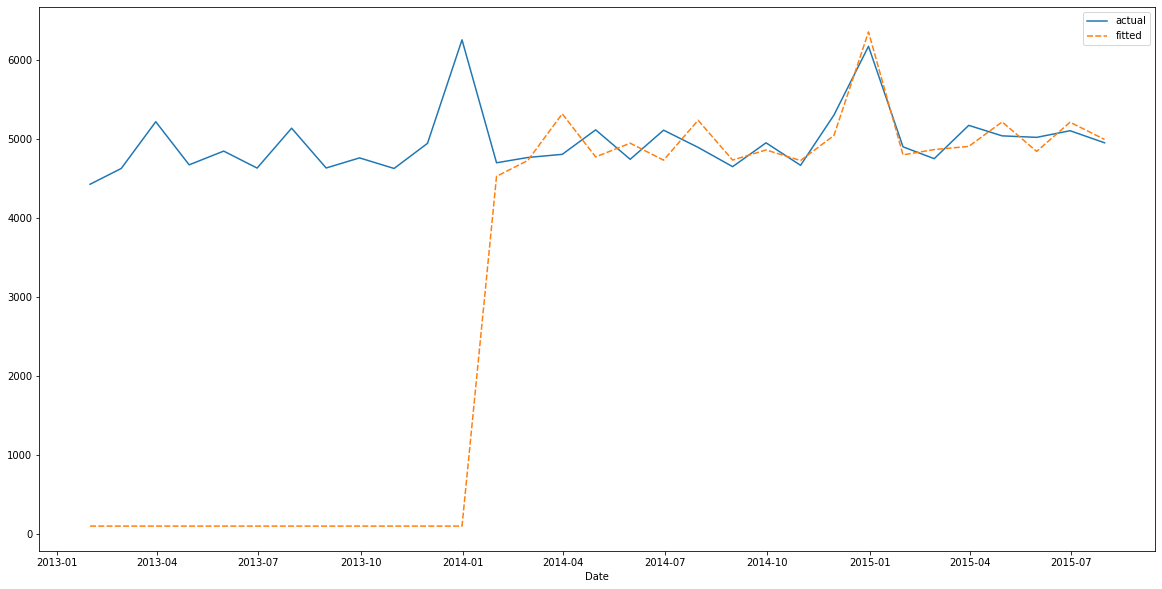

In [216]:
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

model: SARIMAX = SARIMAX(y_t, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend='c')
model_fit: ARIMAResults = model.fit(disp=False)
model_fit.summary()

errors_dict: dict[str, float] = errors(y_t.iloc[12:], model_fit)
errors_dict

# Plot actual vs fitted values
plot_actual_and_fitted_values(y_t, model_fit)


##  Residuals diagnostics
The residuals of the model should be white noise. Difference of fitted vs actual values). if yes model is good, see [here](https://machinelearningmastery.com/white-noise-time-series-python/) and [here](https://otexts.com/fpp3/diagnostics.html) why.

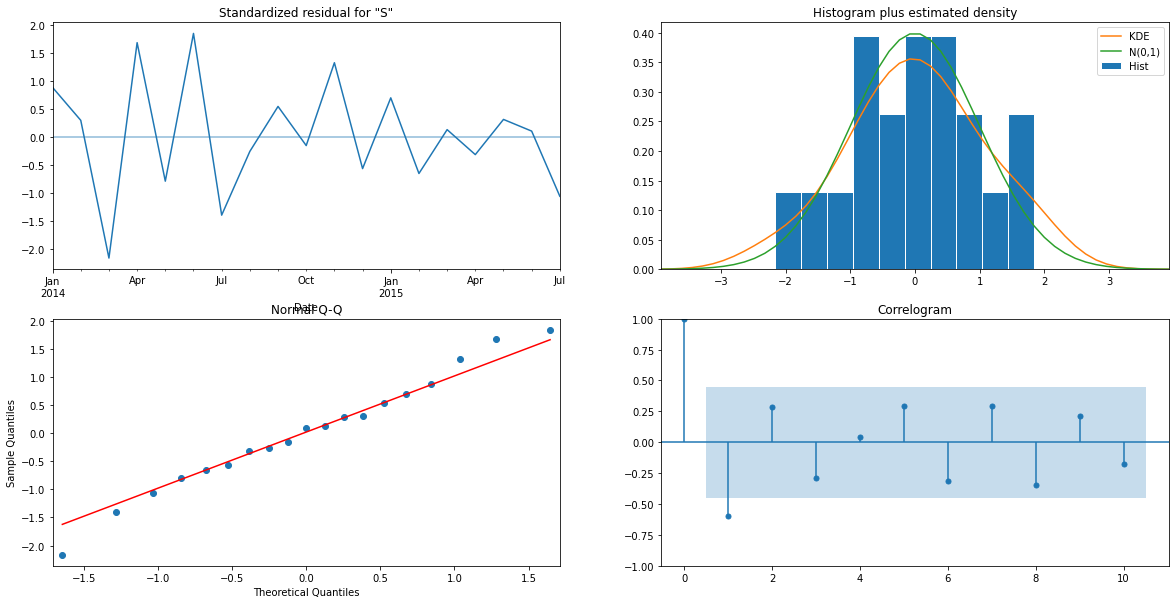

In [207]:
from matplotlib.pyplot import Figure

figure: Figure = model_fit.plot_diagnostics(lags=10, figsize=(20, 10))
plt.show()

##
# plot_series_acf_histogram(model_fit.resid.iloc[12:], lags=10)

## Model accuracy
It is important to evaluate forecast accuracy using genuine forecasts. Consequently, the size of the residuals is not a reliable indication of how large true forecast errors are likely to be. The accuracy of forecasts can only be determined by considering how well a model performs on new data that were not used when fitting the model.
See [here](https://otexts.com/fpp3/accuracy.html) for more info.

In [208]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

for y_train_idx, y_test_idx in TimeSeriesSplit(n_splits=5, test_size=2).split(y_t):
    y_train = y_t.iloc[y_train_idx]
    #regressor: ARIMA = ARIMA(endog=y_train)
    #model_fit = regressor.fit()
    #print('Coefficients: %s' % model_fit.params)
    # result: AutoRegResults = model_fit.predict(start=20, end=22)


# Decomposition | Time series decomposition in Trend, Seasonal and Residuals
Decompose to extract trend cycle for better ACF with the Seasonal component with yt = S+T+R cause we have a additive decompoition in _classical decomposition_ cause the changes in trend and seasonality are linear changing (trend) and constant (seasonality period).

1. [General Time series decomposition](https://otexts.com/fpp3/classical-decomposition.html)
2. [Very short intro to STL](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality)

### Additive classical decomposition
yt = St + Tt + Rt using MA (moving average). See the yearly same pattern of _S_ component.

1. [Additive classical decomposition with examples in python statsmodel](https://otexts.com/fpp3/classical-decomposition.html#additive-decomposition)

In [209]:
# LIB DECOMPOSITION
def plot_decompose_result(stl_decomp_result):
    f: plt.Figure = stl_decomp_result.plot()
    f.set_size_inches(w=20, h=20)
    plt.show()

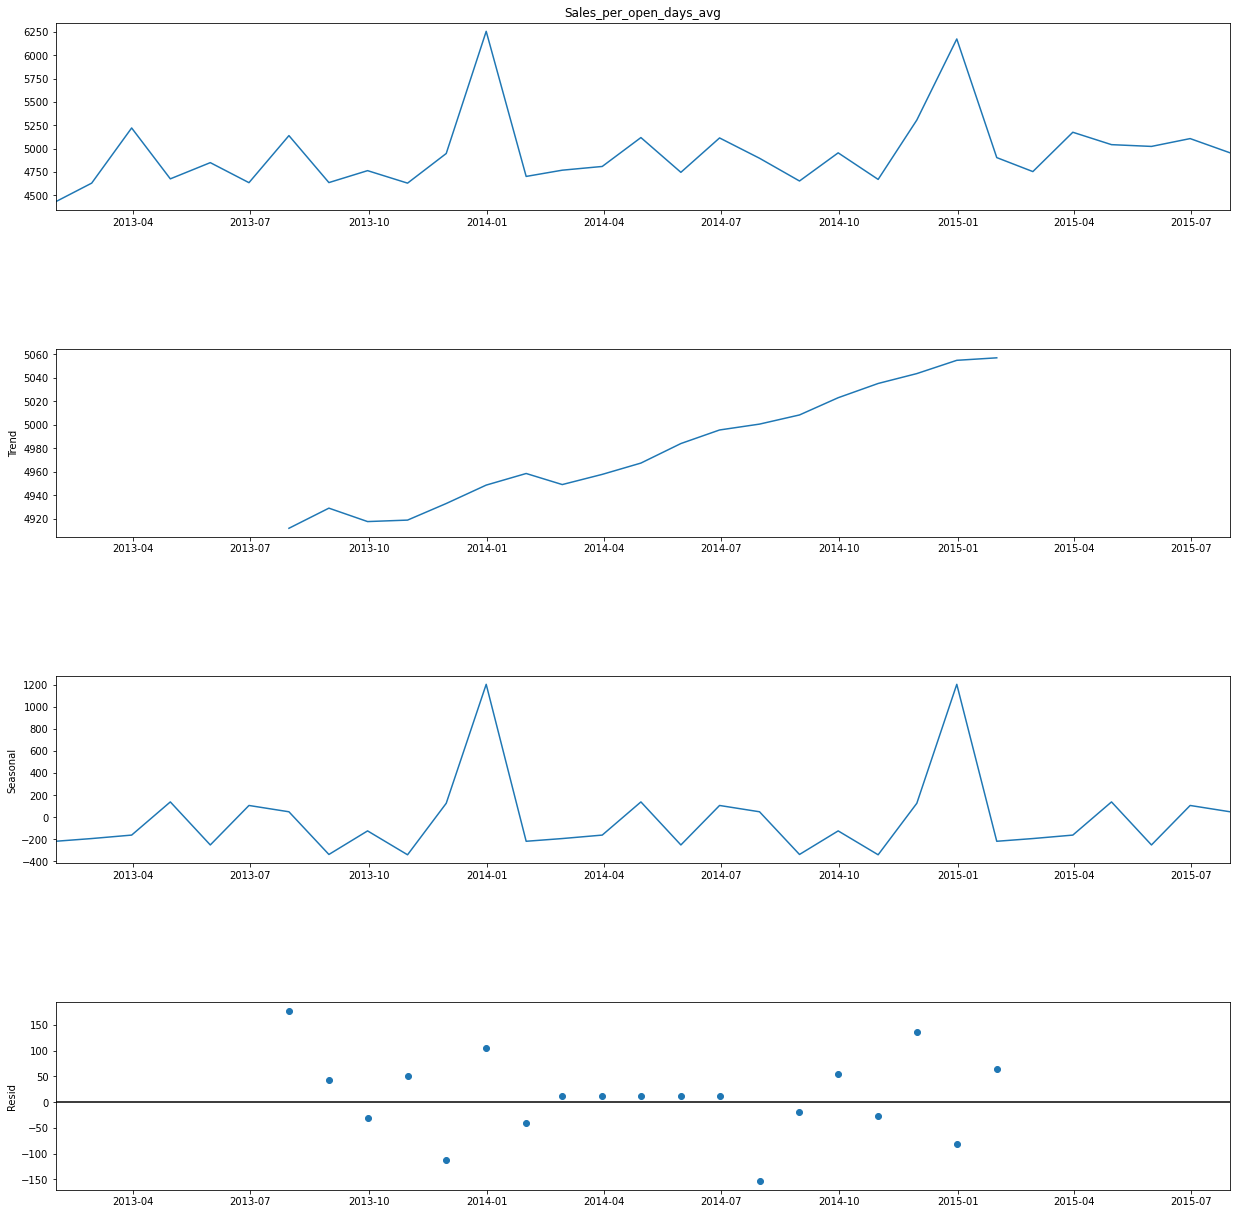

NameError: name 'plot_series_acf_histogram' is not defined

In [210]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

stl_decomp_result: DecomposeResult = seasonal_decompose(y_t, model="additive", period=12, two_sided=True, extrapolate_trend=0)


plot_decompose_result(stl_decomp_result)

# residuals are white noise now?
plot_series_acf_histogram(stl_decomp_result.resid)

# formal autocorrelation test of residuals -> small p-value means each lag correlation value is relative small
#acorr_ljungbox(stl_decomp_result.resid, lags=13)

f = plot_acf(stl_decomp_result.resid, lags=14)
plt.show()


## STL decomposition

In [ ]:
from statsmodels.tsa.seasonal import DecomposeResult
from matplotlib.figure import Figure
from statsmodels.tsa._stl import STL

# The period of 12 is inferred by the DataFrame's index frquency M and assumed to be 12 using 2x12-MA for even number
stl = STL(y_t, trend=13, period=12)
stl_decomp_result: DecomposeResult  = stl.fit()

plot_decompose_result(stl_decomp_result)

f = plot_acf(stl_decomp_result.resid, lags=14)
plt.show()


# residuals are white noise now?
plot_series_hist_acf_kpss(stl_decomp_result.resid)



